# Proyecto 5: Análisis de sentimiento en reviews de películas

En este proyecto vamos a trabajar con un dataset de reviews de películas. El objectivo es clasificar cada comentario de acuerdo al sentimiento positivo o negativo hacia la película. Para hacerlo, vamos a trabajar con procesamiento de texto para luego aplicar las diferentes técnicas predictivas que hemos visto.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import joblib
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from sklearn.datasets import load_files
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_predict
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,VotingClassifier
from sklearn.metrics import classification_report,precision_recall_curve,roc_curve,roc_auc_score,plot_confusion_matrix, accuracy_score

%matplotlib inline

## Dataset

En primer lugar, carguemos las reviews para comenzar a procesarlas. En este caso no tenemos un archivo `.csv`, sino un directorio estructurado de la siguiente forma: 
```
movie_reviews/
  neg/
  pos/
```
`sklearn` nos provee de la función `load_files` que permite recorrer este tipo de estructuras. 

In [2]:
moviedir = r'./dataset/movie_reviews' 
movie_reviews = load_files(moviedir, shuffle=True)

Ahora en la variable `movies` tendremos guardadas las reviews (`movies.data`) y su sentimiento (`movies.target`).
Veamos cuantas reviews tenemos en total:

In [3]:
print("Tenemos {} reviews, con clases {},".format(len(movie_reviews.data), movie_reviews.target_names))

Tenemos 2000 reviews, con clases ['neg', 'pos'],


Analizando la estructura de los documentos, veamos como luce una muestra de `movies.data`:

In [4]:
movie_reviews.data[0][:500]

b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so cal"

Y ahora, con la propiedad `target` podemos ver la categoría asociada a esta review

In [5]:
movie_reviews.target[0]

0

En este caso es un 0, es decir `neg`.

## Exploración y Prepocesamiento

### Llevando todo el texto a minúscula

In [6]:
print('Reviews format: ', type(movie_reviews.data[0]))
print('Target format: ',type(movie_reviews.target[0]))

Reviews format:  <class 'bytes'>
Target format:  <class 'numpy.int64'>


Ya que nos encontramos con un array de bytes se llevarán a minúsculas y se decodificarán.

In [7]:
movie_reviews.data = [review.strip().lower().decode() for review in movie_reviews.data[0:]]

### Remover Plurales y Stop Words

In [8]:
stop_words = set(stopwords.words('english'))
tknzr = TweetTokenizer()
wnl = WordNetLemmatizer()

for i in range(0,len(movie_reviews.data[:])):
    review = movie_reviews.data[i][:]
    no_plurals = [wnl.lemmatize(w).strip() for w in tknzr.tokenize(review) if not w in stop_words]
    movie_reviews.data[i]= ' '.join(no_plurals)

### Remover puntuación

Puntuación (comas,puntos, punto y coma, comillas) y saltos de página serán removidos

In [9]:
for i in [",",".",";",'"','\n','[',']','(',')','{','}','!','-','?',"'"]:
    movie_reviews.data = [review.replace(i,'') for review in movie_reviews.data[:]]
movie_reviews.data[0][:500]

'arnold schwarzenegger icon action enthusiast  since late 80   lately film sloppy oneliner getting worse  hard seeing arnold mr  freeze batman robin  especially say ton ice joke  hey got 15 million  whats matter  arnold signed another expensive blockbuster  cant compare like terminator series  true lie even eraser  called dark thriller  devil  gabriel byrne  come upon earth  impregnate woman  robin tunney  happens every 1000 year  basically destroy world  apparently god chosen one man  one man je'

Las contracciones serán eliminadas en la vectorización.

### Word Cloud
Echemos un vistazo a las palabras más comunes en el dataset

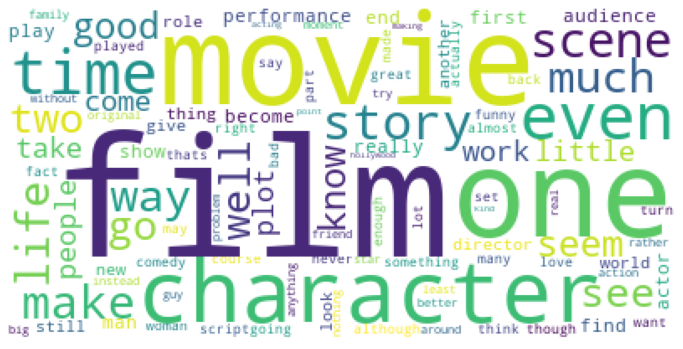

In [10]:
text= str(movie_reviews.data[:][:])
wordcloud = WordCloud(max_words=100,background_color='white').generate(text)
plt.figure(figsize = (12,12))
plt.imshow(wordcloud,interpolation='antialiased',aspect='equal')
plt.axis('off')
plt.show()

## Separando en conjuntos de entrenamiento y de testeo

Antes de comenzar con el entrenamiento de los modelos probando distintos algoritmos para encontrar los mejores modelos, vamos a separar el conjunto de reviews en training y testing. 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    movie_reviews.data, movie_reviews.target, test_size = 0.20, stratify=movie_reviews.target, random_state = 12)

## Preprocesamiento

Para trabajar con texto tenemos que realizar una serie de pasos antes de poder entrenar un modelo. Es decir, buscar la forma de convertir el texto a una representación numérica que pueda ser interpretable por los algoritmos de clasificación. 
Para ello vamos a realizar una serie de pasos.
- Tokenizar el texto
- Convertir a vectores de términos/documentos
- Aplicar tfidf


Es importante destacar que el `fit` debe hacerse sobre el conjunto de `train` y no sobre el total, ya que `tfidf` tiene en cuenta la frecuencia de aparición de las palabras respecto al total del conjunto. Una vez que usamos el `fit` con el conjunto de entrenamiento podemos aplicar la transformación al conjunto de `test`. 

**1) Vectorizá** los textos para obtener una matriz de términos/documentos utilizando td-idf. 

In [12]:
tfidf_vect = TfidfVectorizer()
X_train = tfidf_vect.fit_transform(X_train)
X_test = tfidf_vect.transform(X_test)

### Dimensión de la matriz de términos
Una vez vectorizados los documentos veamos qué forma tiene la matriz resultante

In [13]:
X_train.shape

(1600, 38956)

__¿ Por qué tiene estas dimensiones ?__

Responder.

Porque el resultado es una matriz de términos por documentos. Por cada término existente en el dataset habrá una columna, ya que no se realizó ningún tipo de filtrado.

## Entrenando los modelos
Una vez que tenemos una matriz con los vectores correspondientes a los documentos luego de aplicarse td-idf podemos comenzar con el proceso de entrenamiento de los modelos. Para eso, vamos a comparar diferentes algoritmos vistos como SVM, Random Forest, AdaBoost, Voting. Y todos los algoritmos complementarios que se quieran introducir. 
Para el entrenamiento de los modelos usaremos GridSearch recorriendo una lista de parámetros según corresponda a cada algoritmo. Además usaremos 5-fold CV y el scoring estará dado por el área bajo la curva roc.

In [14]:
#Se crea un diccionario que contendrá cada uno de los mejores modelos obtenidos con el GridSearchCV
best_models = {}

### Funciones para Entrenamiento y Verificación  
Definamos unas funciones que se reutilizarán el proceso de entrenamiento y verificación de los resultados obtenidos para cada uno de los modelos.
#### Grid Search
Con el fin de realizar el recorrido 

In [15]:
def Grid_Search(parameters,model):
    
    grid_search = GridSearchCV(estimator=model, 
                           scoring = 'roc_auc',
                           param_grid=parameters,
                           return_train_score = True,
                           cv = 5,
                           n_jobs = -1,
                           verbose = 2)
    
    grid_search = grid_search.fit(X_train, y_train)
    
    grid_scores = pd.DataFrame(grid_search.cv_results_['params'])
    grid_scores['mean_train_score'] = grid_search.cv_results_['mean_train_score']
    grid_scores['mean_test_score'] = grid_search.cv_results_['mean_test_score']
    
    grid_best_params = grid_search.best_params_
    
    optimised_model = grid_search.best_estimator_
    
    
    return grid_search, grid_scores, grid_best_params, optimised_model

#### ROC Curve

In [16]:
def plot_roc_curve(y_train,y_scores, ax=None,label=None):
    if ax is None:
        ax = plt.gca()
    fpr,tpr,thresholds = roc_curve(y_train,y_scores)
    ax.plot(fpr,tpr,linewidth=2,label=(label))
    ax.plot([0,1],[0,1],'k--',label='No-Skill')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive (Recall)')
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    ax.legend(loc='lower right')
    ax.set_title(str(label)+str(f' - AUC = {round(roc_auc_score(y_train,y_scores),2)}'))

#### Precision-Recall & ROC Curve
Con el propósito de analizar los clasificadores se debe definir un _threshold,_ el cual compone una frontera de dicisión en la cual todo _score_ que sea mayor que el primero será clasificado como la clase positiva, es decir, un review marcado como `pos`.

In [17]:
def plot_precision_recall_curve(y_true,y_scores,label=None, ax =None):
    if ax is None:
        ax = plt.gca()
        
    precisions, recalls, thresholds = precision_recall_curve(y_true,y_scores)
    
    
    ax.set_title(str(label))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.plot(recalls,precisions,label=label)
    ax.plot([0, 1], [0, 0], 'k--', label='No Skill')
    ax.set_xlim([0, 1])
    ax.set_ylim([-0.01, 1])
    ax.legend(loc='lower right')

### Support Vector Machines (SVM)

__Ajustar un SVM (kernel lineal) al conjunto de datos de entrenamiento y devolver la matriz de confusión en testing.__

Basándonos en el paper https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf, vamos a utilizar un kernel lineal. Al tener menos instancias que features este es el procedimiento recomendado. 

Nuestro espacio de parámetros para recorrer de forma exhaustiva utilizando GridSearch será el siguiente:

* C = [0.001, 0.01, 0.1, 1, 10]
* loss = ['hinge', 'squared_hinge'] 

**2) Entrenar** un `LinearSVC` utilizando `Grid Search` y el clasificador `LinearSVC` con `5-fold` cross validation.

In [18]:
%%time
parameters = {'C':[0.001, 0.01, 0.1, 1,10],
              'loss':['hinge', 'squared_hinge']}

svc = LinearSVC(random_state = 0)

grid_search, grid_scores, grid_best_params, optimised_model = Grid_Search(parameters,svc)

best_models[str(type(optimised_model).__name__)] = optimised_model

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    3.1s remaining:    0.5s


CPU times: user 225 ms, sys: 101 ms, total: 326 ms
Wall time: 4.69 s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.5s finished


Veamos los resultados promediados por cada combinación de parámetros:

In [19]:
grid_scores

,C,loss,mean_train_score,mean_test_score
0,0.001,hinge,0.982798,0.880258
1,0.001,squared_hinge,0.983285,0.880641
2,0.010,hinge,0.982798,0.880258
3,0.010,squared_hinge,0.986538,0.884758
4,0.100,hinge,0.982798,0.880258
5,0.100,squared_hinge,0.997983,0.905352
6,1.000,hinge,0.999881,0.922813
7,1.000,squared_hinge,1.000000,0.923531
8,10.000,hinge,1.000000,0.921945
9,10.000,squared_hinge,1.000000,0.922789


### Random Forests
El siguiente modelo que vamos a entrenar es utilizando la técnica de Random Forest. 

**3) Entrenar** un `RandomForest` utilizando `Grid Search` y con `5-fold` cross validation dado el siguiente espacio de búsqueda:

* n_estimators = [100, 500, 1000]
* max_depth: [3, 7, None]
* min_samples_split: [2, 3, 10]
* bootstrap: [True, False]
* criterion: ["gini", "entropy"]

(puede tardar un poco la ejecución dado el tamaño del dataset)

In [20]:
%%time
parameters = {'max_depth':[3, 7, None],
              'bootstrap':[True, False],
              'min_samples_split':[2, 3, 10],
              'criterion':["gini", "entropy"],
              'n_estimators':[100, 500, 1000]}

rf = RandomForestClassifier(random_state=0)

grid_search, grid_scores, grid_best_params, optimised_model = Grid_Search(parameters,rf)

best_models[str(type(optimised_model).__name__)] = optimised_model

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 30.0min finished


CPU times: user 22.9 s, sys: 141 ms, total: 23 s
Wall time: 30min 23s


Veamos los resultados promediados por cada combinación de parámetros:

In [21]:
grid_scores

,bootstrap,criterion,max_depth,min_samples_split,n_estimators,mean_train_score,mean_test_score
0,True,gini,3.0,2,100,0.961694,0.840617
1,True,gini,3.0,2,500,0.982109,0.881562
2,True,gini,3.0,2,1000,0.984925,0.887773
3,True,gini,3.0,3,100,0.961625,0.840344
4,True,gini,3.0,3,500,0.982022,0.881586
...,...,...,...,...,...,...,...
103,False,entropy,NaN,3,500,1.000000,0.902066
104,False,entropy,NaN,3,1000,1.000000,0.905809
105,False,entropy,NaN,10,100,1.000000,0.886641
106,False,entropy,NaN,10,500,1.000000,0.903117


### Multilayer Perceptron

**4) Entrenar** un `Multilayer Perceptron` utilizando `Grid Search` y con `5-fold` cross validation dado el siguiente espacio de búsqueda:

El `param_grid` debe recorrer estos valores: `{'hidden_layer_sizes': [(10,),(5,5), (2,2)]}`

In [22]:
%%time
parameters = {'hidden_layer_sizes':[(10,),(5,5), (2,2)]}

m_perc = MLPClassifier(random_state=0)

grid_search, grid_scores, grid_best_params, optimised_model = Grid_Search(parameters, m_perc)

best_models[str(type(optimised_model).__name__)] = optimised_model

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.3min finished


CPU times: user 56.1 s, sys: 35.1 s, total: 1min 31s
Wall time: 1min 41s


Veamos los resultados promediados por cada combinación de parámetros:

In [23]:
grid_scores

,hidden_layer_sizes,mean_train_score,mean_test_score
0,"(10,)",1.000000,0.912539
1,"(5, 5)",1.000000,0.905813
2,"(2, 2)",0.999371,0.906613


### AdaBoost

**5) Entrenar** un `AdaBoost` utilizando `Grid Search` y con `5-fold` cross validation dado el siguiente espacio de búsqueda:

El `param_grid` debe recorrer estos valores: `{'n_estimators': [50, 100, 500]}`


In [24]:
%%time

parameters = {'n_estimators': [50, 100, 500]}

adab = AdaBoostClassifier(random_state=0)

grid_search, grid_scores, grid_best_params, optimised_model = Grid_Search(parameters, adab)

best_models[str(type(optimised_model).__name__)] = optimised_model

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.9min finished


CPU times: user 29.4 s, sys: 39.1 ms, total: 29.4 s
Wall time: 3min 22s


Veamos los resultados promediados por cada combinación de parámetros:

In [25]:
grid_scores

,n_estimators,mean_train_score,mean_test_score
0,50,0.957426,0.815816
1,100,0.995959,0.841055
2,500,1.000000,0.870695


### Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(n_jobs=-1, max_iter=300,random_state=0)
logistic.fit(X_train, y_train)
best_models[str(type(logistic).__name__)] = logistic

### SGD Classifier

In [27]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=0,alpha=1e-5,epsilon=1e-2,average=True,loss='log',early_stopping=True)
sgd.fit(X_train,y_train)
best_models[str(type(sgd).__name__)] = sgd

## Resumen de Resultados

**6) Mostrá** los resultados de la predicción de los clasificadores sobre el conjunto de test con una matriz de confusión.

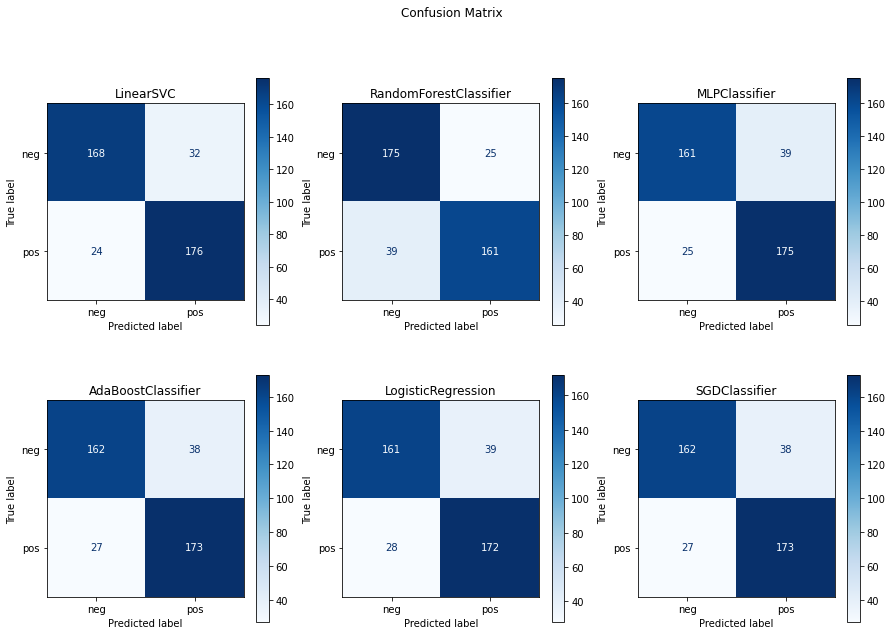

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
fig.suptitle('Confusion Matrix')

for model, ax in zip(best_models, axes.flatten()):
    estimator = best_models[str(model)]
    
    plot_confusion_matrix(estimator, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='Blues',
                          display_labels=movie_reviews.target_names)
    ax.title.set_text(type(estimator).__name__)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
plt.show()

**7) Calcular** el área bajo la curva ROC (AUC) en el conjunto de testing para el modelo y mostrá el `classification_report`

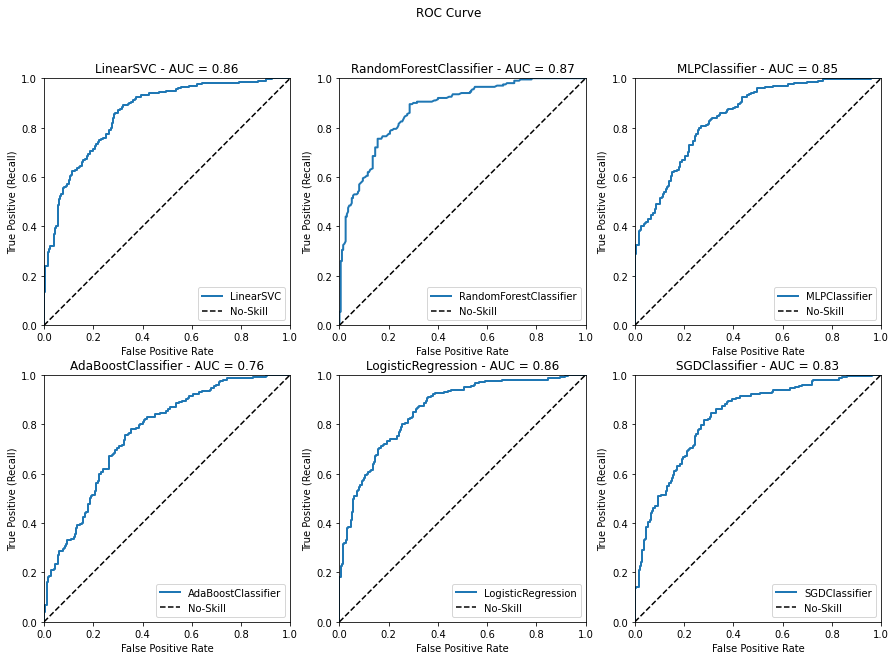

In [29]:
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(15,10))
fig.suptitle('ROC Curve')

for model,ax in zip(best_models,ax.flatten()):
    
    estimator = best_models[str(model)]
    
    if (model =='RandomForestClassifier') or (model=='MLPClassifier'):
        method = 'predict_proba'
        y_scores = cross_val_predict(estimator,X_test,y_test,cv=3,method=method)
        y_scores = y_scores[:,1]
    else:
        method = 'decision_function'
        y_scores = cross_val_predict(estimator,X_test,y_test,cv=3,method=method)
    plot_roc_curve(y_test,y_scores,label=str(type(estimator).__name__),ax=ax)
plt.show()

In [30]:
for model in best_models:
    
    estimator = best_models[str(model)]
    y_pred = best_models[str(model)].predict(X_test)
    report = classification_report(y_test, y_pred, target_names=movie_reviews.target_names,output_dict=True)
    clsf_report = pd.DataFrame(report).transpose()
    print(model)
    print(clsf_report)
    print()

LinearSVC
              precision  recall  f1-score  support
neg            0.875000    0.84  0.857143   200.00
pos            0.846154    0.88  0.862745   200.00
accuracy       0.860000    0.86  0.860000     0.86
macro avg      0.860577    0.86  0.859944   400.00
weighted avg   0.860577    0.86  0.859944   400.00

RandomForestClassifier
              precision  recall  f1-score  support
neg            0.817757   0.875  0.845411   200.00
pos            0.865591   0.805  0.834197   200.00
accuracy       0.840000   0.840  0.840000     0.84
macro avg      0.841674   0.840  0.839804   400.00
weighted avg   0.841674   0.840  0.839804   400.00

MLPClassifier
              precision  recall  f1-score  support
neg            0.865591   0.805  0.834197   200.00
pos            0.817757   0.875  0.845411   200.00
accuracy       0.840000   0.840  0.840000     0.84
macro avg      0.841674   0.840  0.839804   400.00
weighted avg   0.841674   0.840  0.839804   400.00

AdaBoostClassifier
             

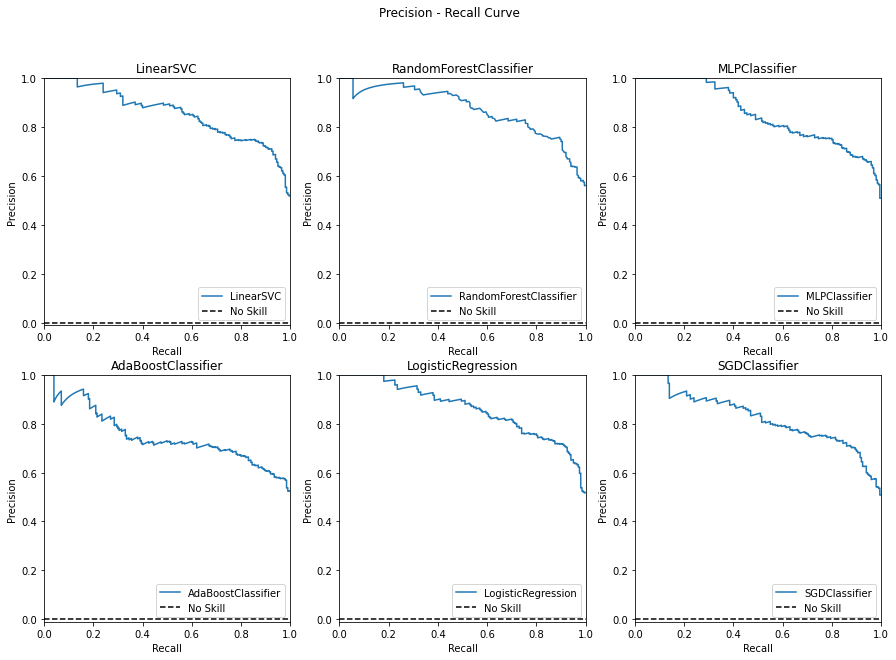

In [31]:
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(15,10))
fig.suptitle('Precision - Recall Curve')

for model,ax in zip(best_models,ax.flatten()):
    
    estimator = best_models[str(model)]
    
    if (model =='RandomForestClassifier') or (model=='MLPClassifier'):
        method = 'predict_proba'
        y_scores = cross_val_predict(estimator,X_test,y_test,cv=3,method=method)
        y_scores = y_scores[:,1]
    else:
        method = 'decision_function'
        y_scores = cross_val_predict(estimator,X_test,y_test,cv=3,method=method)
    
    estimator = best_models[str(model)]
    plot_precision_recall_curve(y_test,y_scores,label=str(type(estimator).__name__),ax=ax)
    
plt.show()

__8) Armar un ensamble__ entre los cuatro modelos usando votación y medir el accuracy de cada uno de los modelos.


In [32]:
models_list = [(k,v) for k,v in best_models.items()]
eclf = VotingClassifier(estimators=models_list, voting='hard',n_jobs=-1,verbose=2)
eclf.fit(X_train, y_train)
best_models[type(eclf).__name__] = eclf

In [33]:
for model in best_models:
    estimator = best_models[str(model)]
    y_pred = estimator.predict(X_test)
    print(type(estimator).__name__, round(accuracy_score(y_test, y_pred),2))

LinearSVC 0.86
RandomForestClassifier 0.84
MLPClassifier 0.84
AdaBoostClassifier 0.84
LogisticRegression 0.83
SGDClassifier 0.84
VotingClassifier 0.86


__9) Seleccioná el modelo__ que te haya dado el mejor score y utilizalo como tu modelo final. Reentrenalo con todos tus datos de entrenamiento.


In [34]:
best_model = best_models['VotingClassifier']
joblib.dump(best_model, 'sentiment.pkl') 

['sentiment.pkl']

In [35]:
#eclf = eclf.fit(X_train, y_train)
y_pred = eclf.predict(X_test)
y_pred

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,

## Clasificación de reviews de Rocky 4.

A partir de [criticas de la película Rocky 4](https://www.rottentomatoes.com/m/rocky_iv/reviews/?type=user) veamos como las clasifica nuestro mejor modelo

In [36]:
reviews_new = ["Stallone creates credible villains worthy of his heroic character.",
               "Another brilliant Rocky film, probably my favourite one out of the lot",
               "Yeah, this movie sucks.",
               "My favourite rocky film! So good so much heart. Slightly better than 2",
               "What has this got to do with boxing. Also everyone looked like dolls. Also if you are a real true boxing fan (not casuals), you would understand that this stupidity is no description of boxing!!",
               "The new film's narrative is stripped down to essentials, which gives it an emblematic quality.",
               "Absurdly ridiculous, this just isn't a good movie at all", 
               "Very basic and predictable but still an okay movie. No special music to save this one.", 
              "Rocky 4 is an extremely ambitious movie that is definitely worth watching.",
              'Highly beautiful',
               "If it wasn't for the robots (WTF????), and the painfully overwritten lines of an absurdly dogmatic persuasion, then this would otherwise be nothing more than an interminable series of mildly rousing montages. There are some unintentionally funny bits though, and Dolph's Ivan showcases the best and worst of all Rocky's opponents.",
              "While all aspects of realism is thrown out the window, ROCKY IV is an adrenaline rush of action and excitment, with an incredible soundtrack and arguably the best movie fight in history between Balboa and Drago",
              "Just like the songs, exercise routines and repetitive clips, it seems redundant to add another installment in this already falling franchise when you clearly lack material. Rocky IV is petty, childish and seems overlong despite of its 91 minutes of run time for it merely has an idea of a TV drama episode which is stretched to a point of exhaustion. Its painful to watch Sylvester Stallone go through this enormous amount of training and hardly make a point out there. He fails on all the levels here; writer, director and actor, to deliver any loose end of the thread for the audience to hang on to. Rocky IV is predictable, loosely written and choreographed and executed unsupervised."]
reviews_new_counts = tfidf_vect.transform(reviews_new)
reviews_new_tfidf = tfidf_vect.transform(reviews_new)

In [37]:
pred = eclf.predict(reviews_new_tfidf)

In [38]:
for review, category in zip(reviews_new, pred):
    print('%r => %s \n' % (review, movie_reviews.target_names[category]))

'Stallone creates credible villains worthy of his heroic character.' => neg 

'Another brilliant Rocky film, probably my favourite one out of the lot' => pos 

'Yeah, this movie sucks.' => neg 

'My favourite rocky film! So good so much heart. Slightly better than 2' => pos 

'What has this got to do with boxing. Also everyone looked like dolls. Also if you are a real true boxing fan (not casuals), you would understand that this stupidity is no description of boxing!!' => neg 

"The new film's narrative is stripped down to essentials, which gives it an emblematic quality." => neg 

"Absurdly ridiculous, this just isn't a good movie at all" => neg 

'Very basic and predictable but still an okay movie. No special music to save this one.' => neg 

'Rocky 4 is an extremely ambitious movie that is definitely worth watching.' => pos 

'Highly beautiful' => pos 

"If it wasn't for the robots (WTF????), and the painfully overwritten lines of an absurdly dogmatic persuasion, then this would oth